**Goal of the project**

In this notebook, we will classify Wikipedia comments into one or more categories of so-called toxic comments. Categories of toxic online behavior include toxic, severe_toxic, obscene, threat, insult, and identity_hate. The dataset can be downloaded from the [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge) as a CSV file (i.e., download the file train.csv).

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import ktrain
import tensorflow as tf
from ktrain import text

**Preprocess data and build a text classification model**

We will load the data using the texts_from_csv function. This function expects one column to contain the texts of documents and one or more other columns to store the labels.

In [3]:
DATA_PATH = '../input/jigsaw-toxic-comment-classification-challenge/train.csv'
NUM_WORDS = 50000
MAXLEN = 150

(x_train, y_train), (x_test, y_test), preproc = text.texts_from_csv(DATA_PATH, 'comment_text',
                                                                    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
                                                                    val_filepath = None, 
                                                                    max_features = NUM_WORDS, 
                                                                    maxlen = MAXLEN,
                                                                    ngram_range = 1)

detected encoding: utf-8 (if wrong, set manually)
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        toxic  severe_toxic  obscene  threat  insult  identity_hate
94264       0             0        0       0       0              0
38494       0             0        0       0       0              0
40813       0             0        0       0       0              0
143555      0             0        0       0       0              0
97918       0             0        0       0       0              0
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        toxic  severe_toxic  obscene  threat  insult  identity_hate
106940      0             0        0       0       0              0
108665      0             0        0       0       0              0
105716      0             0        0       0       0              0
359         0             0        0       0       0              0
15297       0             0        0       0       0  

In [4]:
# Call the print_text_classifiers to show the available text classification models
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


Next, we load a text classification model and wrap the model and data in Learner object. 

In [5]:
model = text.text_classifier('fasttext', (x_train, y_train), preproc = preproc)

Is Multi-Label? True
compiling word ID features...
maxlen is 150
done.


In [6]:
# Wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, train_data = (x_train, y_train), val_data = (x_test, y_test), batch_size = 16)

**Estimate a good learning rate**

To train the model, we will first find the optimal learning rate that suits well to our problem. ktrain provides a very good method named lr_find which trains the model at different learning rates and plots loss of the model as the learning rate is increased.

In [7]:
# Briefly simulate training to find good learning rate
learner.lr_find(max_epochs = 3) 

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
8976/8976 [==============================] - 45s 5ms/step - loss: 0.6720 - accuracy: 0.1934
Epoch 2/3
8976/8976 [==============================] - 43s 5ms/step - loss: 0.1241 - accuracy: 0.7062
Epoch 3/3
8976/8976 [==============================] - 34s 4ms/step - loss: 9.3041 - accuracy: 0.8787


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


The learning rate plot can be observed by calling the following method:

Three possible suggestions for LR from plot:
	Longest valley (red): 7.48E-05
	Min numerical gradient (purple): 4.55E-05
	Min loss divided by 10 (omitted from plot): 2.37E-03


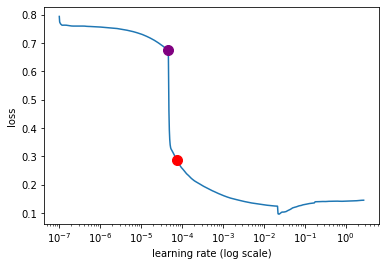

In [8]:
# Visually identify best learning rate
learner.lr_plot(suggest = True)

We will now train the model using the autofit method. The method trains the classifier and automatically selects the best performing one preventing underfitting and overfitting of the model.

In [9]:
# Training using the autofit policy
learner.autofit(7.48E-05, early_stopping = 5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 7.48e-05...
Epoch 1/1024
8976/8976 [==============================] - 53s 6ms/step - loss: 0.2842 - accuracy: 0.3348 - val_loss: 0.1036 - val_accuracy: 0.9437
Epoch 2/1024
8976/8976 [==============================] - 52s 6ms/step - loss: 0.1179 - accuracy: 0.6135 - val_loss: 0.0724 - val_accuracy: 0.9877
Epoch 3/1024
8976/8976 [==============================] - 52s 6ms/step - loss: 0.0934 - accuracy: 0.7781 - val_loss: 0.0614 - val_accuracy: 0.9928
Epoch 4/1024
8976/8976 [==============================] - 53s 6ms/step - loss: 0.0811 - accuracy: 0.8938 - val_loss: 0.0568 - val_accuracy: 0.9931
Epoch 5/1024
8976/8976 [==============================] - 52s 6ms/step - loss: 0.0751 - accuracy: 0.9489 - val_loss: 0.0560 - val_accuracy: 0.9932
Epoch 6/1024
8976/8976 [==============================] - 52s 6ms/step - loss: 0.0703 - accuracy: 0.9736 - val_loss: 0.0551 - val

**Making predictions**

In [10]:
y_pred = learner.model.predict(x_test)

**Evaluate model**

Let's compute for ROC-AUC of our final model for identifying toxic online behavior:

In [11]:
from sklearn.metrics import roc_auc_score

In [12]:
# Evaluate model
score = roc_auc_score(y_test, y_pred)
print("\n ROC-AUC score: %.6f \n" % (score))


 ROC-AUC score: 0.974877 



Our final ROC-AUC score is **0.97**.